## Курсовой проект

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as sc
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data_tst = pd.read_csv('test.csv')
df_tst   = pd.DataFrame(data_tst)
data_trn = pd.read_csv('train.csv')
df_trn   = pd.DataFrame(data_trn)

In [3]:
X_tst = pd.DataFrame(df_tst,columns=['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
       'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
       'Helthcare_2', 'Shops_1', 'Shops_2'])
X_trn = pd.DataFrame(df_trn,columns=['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
       'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
       'Helthcare_2', 'Shops_1', 'Shops_2'])
y_trn = pd.DataFrame(df_trn,columns=['Price'])

Починка данных в консолидированном (как в тренировочном, так и в тестовом) наборе

In [4]:
X_cons = pd.concat([X_trn,X_tst]) # первые 10000 - тренировочные, затем 5000 - тестовые

In [5]:
# скорректируем ошибки в году постройки:
X_cons[X_cons.HouseYear>2020]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
1497,10814,109,1.0,37.265070,20.239714,9.0,9,12.0,20052011,0.136330,B,B,30,6141,10,262.0,3,6,B
4189,11607,147,2.0,44.791836,28.360393,5.0,4,9.0,4968,0.319809,B,B,25,4756,16,2857.0,5,8,B


In [6]:
X_cons.loc[X_cons.Id==10814,'HouseYear']=2005
X_cons.loc[X_cons.Id==11607,'HouseYear']=1968

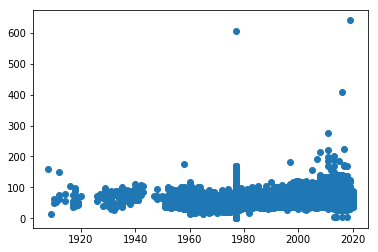

In [7]:
plt.scatter(X_cons.HouseYear, X_cons.Square)
# выбросы по году постройки убрали

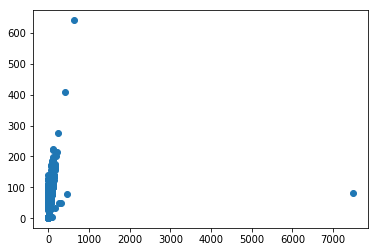

In [8]:
# теперь надо устранить артефакты с жилой площадью, что больше общей
plt.scatter(X_cons.LifeSquare, X_cons.Square)

In [9]:
X_cons.LifeSquare = np.where(X_cons.Square<X_cons.LifeSquare, X_cons.Square, X_cons.LifeSquare)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
4262,28,9,2.0,604.705972,NaN,1.0,17,18.0,1977,0.161532,B,B,25,5648,1,30.0,2,4,B
4690,2307,102,1.0,409.425181,409.425181,10.0,4,4.0,2016,0.238617,B,B,26,3889,6,705.0,3,6,B
6977,11602,30,2.0,641.065193,638.163193,10.0,20,19.0,2019,0.000078,B,B,22,6398,141,1046.0,3,23,B


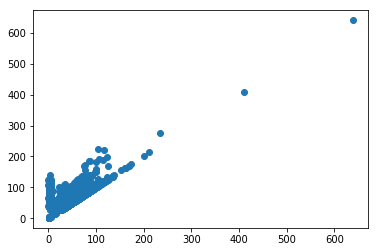

In [10]:
plt.scatter(X_cons.LifeSquare, X_cons.Square)
X_cons[X_cons.Square>300]

In [11]:
X_cons[X_cons.LifeSquare>300]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
4690,2307,102,1.0,409.425181,409.425181,10.0,4,4.0,2016,0.238617,B,B,26,3889,6,705.0,3,6,B
6977,11602,30,2.0,641.065193,638.163193,10.0,20,19.0,2019,0.000078,B,B,22,6398,141,1046.0,3,23,B


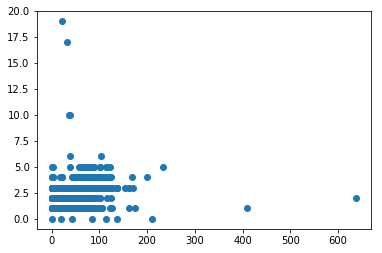

In [12]:
plt.scatter(X_cons.LifeSquare, X_cons.Rooms)
# надо устранить артефакты с количеством комнат более 6, а так же с огромной площадью общей и жилой, это при 2х комнатах!!

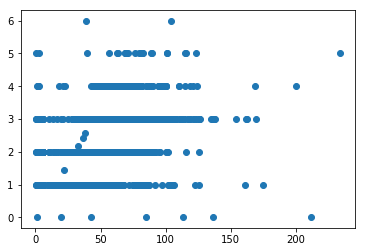

In [13]:
S_per_R = X_cons.LifeSquare.sum()/X_cons.Rooms.sum()
X_cons.Rooms      = np.where(X_cons.Rooms>6,       X_cons.LifeSquare/S_per_R, X_cons.Rooms)
X_cons.Square     = np.where(X_cons.Square>300,    X_cons.Square/10,          X_cons.Square)
X_cons.LifeSquare = np.where(X_cons.LifeSquare>300,X_cons.LifeSquare/10,      X_cons.LifeSquare)
plt.scatter(X_cons.LifeSquare, X_cons.Rooms)

In [14]:
# заполним недостающую жилую площадь:
S_per_K = X_cons.KitchenSquare.sum()/X_cons.Id.count()
X_cons.LifeSquare = np.where(X_cons.LifeSquare.isnull(), X_cons.Square-S_per_K, X_cons.LifeSquare)

In [15]:
# Восполним недостающие значения Healthcare_1. 
HC_mn   = X_cons.Healthcare_1[X_cons.Healthcare_1.notnull()].mean()
X_cons.Healthcare_1 = np.where(X_cons.Healthcare_1.isnull(), HC_mn, X_cons.Healthcare_1)

In [16]:
# получили обработанные наборы данных
X_trn_c = X_cons[0:10000]
X_tst_c = X_cons[10000:15000]

## Этап 2: применение модели линейной регрессии

In [17]:
# выделим ограниченный набор признаков и нормализуем его
from sklearn.preprocessing import StandardScaler
X_trn_4 = X_trn_c[{'Rooms','Square','LifeSquare','KitchenSquare','Floor','HouseFloor','HouseYear','Ecology_1','Social_1','Social_2','Social_3','Healthcare_1'}]

scaler = StandardScaler()
scaler.fit(X_trn_4)
X_trn_sc = scaler.transform(X_trn_4)

C:\Users\Gry\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Gry\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  import sys


In [18]:
from sklearn.model_selection import train_test_split
Xt_trn, Xt_tst, yt_trn, yt_tst = train_test_split(X_trn_sc, y_trn, test_size=0.20, random_state=42)

In [19]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
lr = LinearRegression()
#ls = Lasso(alpha = 0.00001)
#rd = Ridge()
lr.fit(Xt_trn,yt_trn)
yt_pred = lr.predict(Xt_tst)

In [20]:
chk_1 = pd.DataFrame({'pred': yt_pred.flatten(),'real':yt_tst.Price},columns=['pred','real'])

In [21]:
from sklearn.metrics import r2_score
r2sc = r2_score(yt_tst,yt_pred)
r2sc # 0.4653 0.4095 0.4733 0.4953

0.4953639342957399

# отработка найденной модели на тестовом наборе

In [22]:
X_tst_4 = X_tst_c[{'Rooms','Square','LifeSquare','KitchenSquare','Floor','HouseFloor','HouseYear','Ecology_1','Social_1','Social_2','Social_3','Healthcare_1'}]
scaler.fit(X_tst_4)
X_tst_sc = scaler.transform(X_tst_4)

C:\Users\Gry\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Gry\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until


In [27]:
y_tst = lr.predict(X_tst_sc)
y_tst.flatten()

array([175867.02296819, 194033.66841584, 152874.86709614, ...,
       368000.65320344, 207900.79277303, 240347.20364261])

In [28]:
pd.Series(y_tst.flatten())

0       175867.022968
1       194033.668416
2       152874.867096
3       276904.932279
4       139441.724067
5       181419.336868
6       193922.695267
7       228966.012033
8       309054.216419
9       264292.421172
10      297110.376943
11      244553.980264
12      179769.797578
13      208609.356083
14      107704.967087
15      174800.471394
16      292651.424125
17      214608.419701
18      306882.029722
19      247273.525302
20      175502.699612
21      115637.394536
22      262293.515631
23      119571.549110
24      188147.961845
25      179336.959033
26      281447.657494
27      130507.802452
28      188272.852098
29      282357.481492
            ...      
4970    218997.254351
4971    135521.931614
4972    143047.778634
4973    130662.060944
4974    153724.478272
4975    385105.971838
4976    168629.151078
4977    158082.676440
4978    165949.398915
4979    166024.098130
4980    274442.300508
4981    177114.070210
4982    102143.297406
4983    128595.188215
4984    14

In [30]:
result=pd.concat([X_tst['Id'],pd.Series(y_tst.flatten())],axis=1).rename(columns={0:'Price'})
result.to_csv('GBaydin_predictions.csv',index=None)